In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd

import json
import sys
import torch
from torch.distributions import Normal

from flowtron import Flowtron
from data import Data
from train import update_params
sys.path.insert(0, "tacotron2")
sys.path.insert(0, "tacotron2/waveglow")
from tacotron2.waveglow.denoiser import Denoiser

### Load Config

In [2]:
config_path = "config.json"
params = ["model_config.dummy_speaker_embedding=0",
          "data_config.p_arpabet=1.0"]

with open(config_path) as f:
    data = f.read()

config = json.loads(data)
update_params(config, params)

data_config = config["data_config"]
model_config = config["model_config"]

ignore_keys = ['training_files', 'validation_files']
trainset = Data(
    data_config['training_files'],
    **dict((k, v) for k, v in data_config.items() if k not in ignore_keys))

speaker_vecs = trainset.get_speaker_id(0).cuda()
text = "Humans are walking on the streets?"
text = trainset.get_text(text).cuda()
text = text[None]

model_config.dummy_speaker_embedding=0
dummy_speaker_embedding=0
data_config.p_arpabet=1.0
p_arpabet=1.0
Number of speakers : 1
Number of speakers : 1


### Load Flowtron

In [3]:
model_path = "checkpoints/flowtron_ljs.pt"
state_dict = torch.load(model_path, map_location='cpu')['state_dict']
model = Flowtron(**model_config)
model.load_state_dict(state_dict)
_ = model.eval().cuda()

### Load Waveglow

In [4]:
waveglow_path = 'checkpoints/waveglow.pt'
waveglow = torch.load(waveglow_path)['model']
_ = waveglow.eval().cuda()
denoiser = Denoiser(waveglow).cuda().eval()

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

### Prepare z

tensor([[[ 1.6673,  1.3326,  0.1177,  ...,  0.1031, -0.0465, -1.5655],
         [ 1.0533,  0.3444,  0.2944,  ...,  0.2343,  0.3051,  1.0289],
         [-0.6747,  1.4044, -0.7158,  ...,  1.1155,  0.7876, -0.2540],
         ...,
         [-1.2666,  0.2281,  0.8889,  ...,  0.3503, -0.7795,  1.1699],
         [ 0.4070, -0.1143, -0.0635,  ...,  0.7656, -0.4415,  0.4015],
         [-0.5893, -0.0293, -0.0122,  ..., -0.5401,  0.4221, -0.5389]]],
       device='cuda:0')
tensor([[[ 3.6983e-01, -1.4246e-01,  4.4977e-01,  ..., -5.7774e-01,
          -9.4455e-01,  1.1241e+00],
         [ 4.7109e-01, -4.2200e-01, -1.3505e-01,  ...,  7.1348e-01,
           2.5600e+00, -5.8828e-01],
         [-6.7015e-01, -6.9561e-01,  3.6821e-04,  ..., -3.3586e-01,
           1.4313e+00,  6.0943e-01],
         ...,
         [-5.3923e-01, -2.0839e-01,  1.1588e+00,  ..., -1.0005e+00,
           1.3137e+00, -8.4885e-01],
         [ 2.5335e-01,  4.6788e-01, -2.5445e-01,  ...,  3.0080e-01,
          -7.9597e-01,  5.9680e-

tensor([[[-1.2975e-02, -1.4750e-02,  3.3205e-03,  ..., -6.8087e-03,
          -8.9808e-03,  2.6896e-02],
         [-5.8217e-03, -7.6638e-03, -4.2946e-03,  ...,  4.7913e-03,
           2.2549e-02, -1.6172e-02],
         [ 4.5845e-05, -2.1000e-02,  7.1613e-03,  ..., -1.4514e-02,
           6.4375e-03,  8.6341e-03],
         ...,
         [ 7.2739e-03, -4.3648e-03,  2.6992e-03,  ..., -1.3508e-02,
           2.0932e-02, -2.0187e-02],
         [-1.5366e-03,  5.8220e-03, -1.9091e-03,  ..., -4.6481e-03,
          -3.5451e-03,  1.9533e-03],
         [-3.8859e-03, -7.4089e-03, -6.5255e-03,  ...,  1.8907e-03,
          -2.5270e-03,  4.2003e-03]]], device='cuda:0')

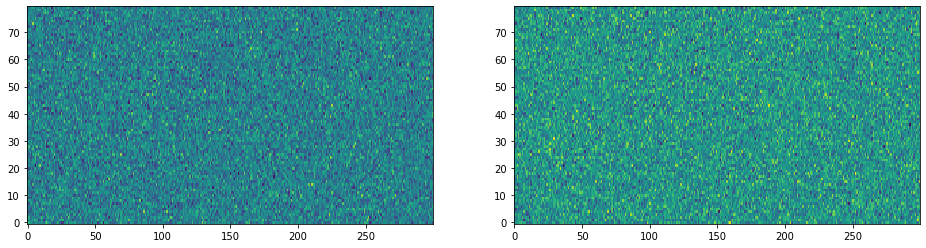

In [5]:
sigma = 0.8
n_frames = 300

z_1 = torch.FloatTensor(1, 80, n_frames).cuda().normal_() * sigma
z_2 = torch.FloatTensor(1, 80, n_frames).cuda().normal_() * sigma

print(z_1)
print(z_2)
    
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].imshow(z_1[0].cpu(), aspect='auto', origin='lower', interpolation='none')
im = axes[1].imshow(z_2[0].cpu(), aspect='auto', origin='lower', interpolation='none')

inter = (z_2 - z_1) / 100
inter

In [6]:
list = [z_1]
for i in range(1, 100):
    list.append(z_1 + inter * i)
list.append(z_2)

### Use model to get Mel

In [7]:
# for i in range(len(list)):
#     z = list[i]
#     mel =  model.infer(z, speaker_vecs, text)[0]
#     fig, axes = plt.subplots(1, 2, figsize=(16, 4))
#     axes[0].imshow(mel[0].cpu().detach().numpy(), origin='lower', aspect='auto')
#     axes[1].imshow(z[0].cpu(), origin='lower', aspect='auto')
#     fig.savefig('Interpolation_experiment/z_{}.png'.format(i))
#     plt.close("all")
print(z_1 - list[0])
print(z_2 - list[100])

len(list)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')


101

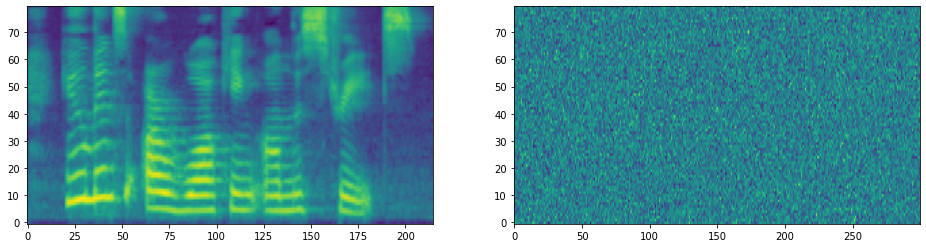

In [10]:
z = list[0]
mel =  model.infer(z, speaker_vecs, text)[0]
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].imshow(mel[0].cpu().detach().numpy(), origin='lower', aspect='auto')
axes[1].imshow(z[0].cpu(), origin='lower', aspect='auto')

with torch.no_grad():
    audio = denoiser(waveglow.infer(mel, sigma=0.75), 0.01)
ipd.Audio(audio[0].data.cpu().numpy(), rate=data_config['sampling_rate'])

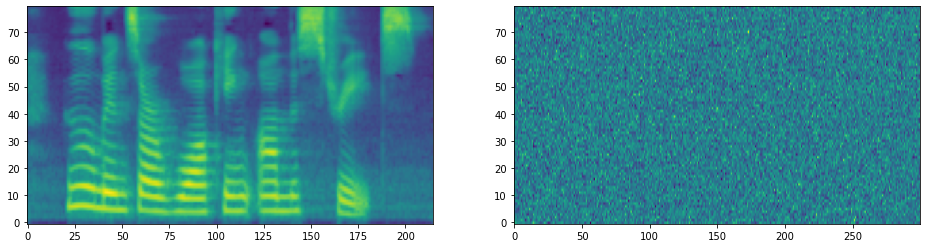

In [11]:
z = list[25]
mel =  model.infer(z, speaker_vecs, text)[0]
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].imshow(mel[0].cpu().detach().numpy(), origin='lower', aspect='auto')
axes[1].imshow(z[0].cpu(), origin='lower', aspect='auto')

with torch.no_grad():
    audio = denoiser(waveglow.infer(mel, sigma=0.75), 0.01)
ipd.Audio(audio[0].data.cpu().numpy(), rate=data_config['sampling_rate'])

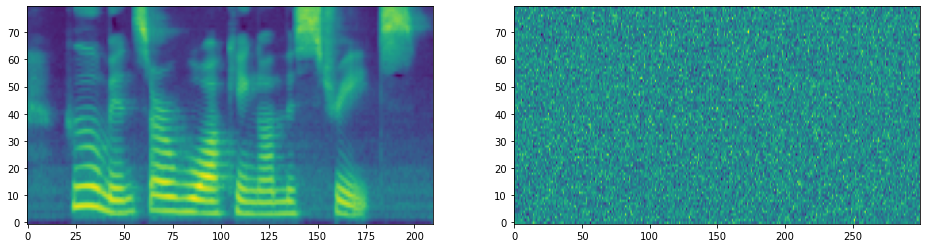

In [12]:
z = list[50]
mel =  model.infer(z, speaker_vecs, text)[0]
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].imshow(mel[0].cpu().detach().numpy(), origin='lower', aspect='auto')
axes[1].imshow(z[0].cpu(), origin='lower', aspect='auto')

with torch.no_grad():
    audio = denoiser(waveglow.infer(mel, sigma=0.75), 0.01)
ipd.Audio(audio[0].data.cpu().numpy(), rate=data_config['sampling_rate'])

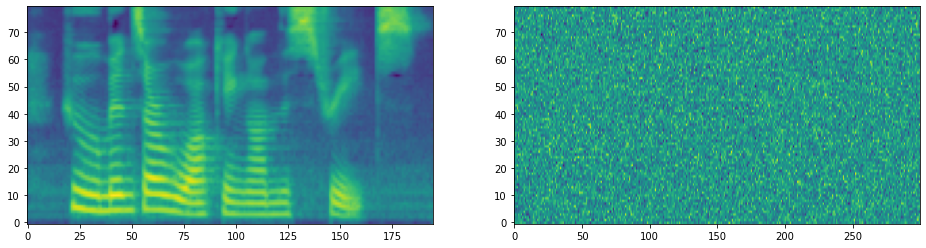

In [13]:
z = list[75]
mel =  model.infer(z, speaker_vecs, text)[0]
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].imshow(mel[0].cpu().detach().numpy(), origin='lower', aspect='auto')
axes[1].imshow(z[0].cpu(), origin='lower', aspect='auto')

with torch.no_grad():
    audio = denoiser(waveglow.infer(mel, sigma=0.75), 0.01)
ipd.Audio(audio[0].data.cpu().numpy(), rate=data_config['sampling_rate'])

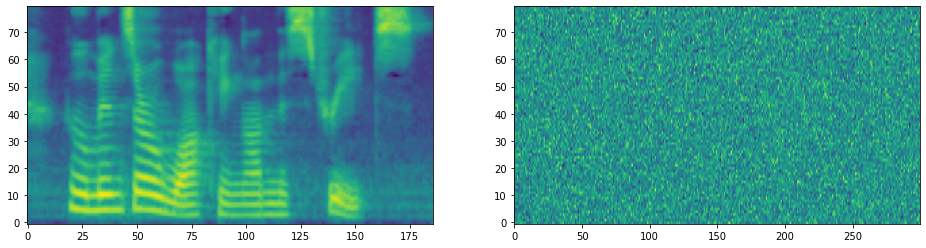

In [14]:
z = list[100]
mel =  model.infer(z, speaker_vecs, text)[0]
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].imshow(mel[0].cpu().detach().numpy(), origin='lower', aspect='auto')
axes[1].imshow(z[0].cpu(), origin='lower', aspect='auto')

with torch.no_grad():
    audio = denoiser(waveglow.infer(mel, sigma=0.75), 0.01)
ipd.Audio(audio[0].data.cpu().numpy(), rate=data_config['sampling_rate'])